<a href="" target="_blank">
  <button style="background-color:#0072ce; color:white; padding:0.6em 1.2em; font-size:1rem; border:none; border-radius:6px; margin-top:1em;">
    🚀 Launch this notebook in JupyterLab
  </button>
</a>

### Introduction

In this section, we will discover how to search and access Sentienl-1 GRD data through EOPF Zarr samples services and how the SAR data is structured inside the groups and subgroups of a `.zarr` product. We will use some of the functions and methods used in the previous  [chapter](22_zarr_struct_S2L2A.ipynb) in order to understand the unique characteristics of Sentinel-1 GRD data.




### What we will learn


-  🗂️ How a Sentinel-1 GRD `.zarr` product is structered?
- 🔎 How to visualize some of the variables inside the `.zarr` product?
- 🚀 The practical meaning of some of these Sentinel-1 GRD variables

### Prerequisites

This tutorial uses a re-processed sample dataset from the [EOPF Sentinel Zarr Samples Service STAC API](https://stac.browser.user.eopf.eodc.eu/). We are using the Sentinel-1 GRD catalog that is available for direct access [here](https://stac.browser.user.eopf.eodc.eu/collections/sentinel-1-l1-grd). 

The selected `.zarr` product that will be used is a Sentinel-1 GRD tile from the 08th of May 2017, from southern Italy area:
* File name: `S1A_IW_GRDH_1SDV_20170508T164830_20170508T164855_016493_01B54C_8604`.

It is uselful to install the extra dependencies from this environment. To do it, we just need to run the following command:
```bash
uv sync --all-extras
```

<hr>

#### Import libraries

In [28]:
import xarray as xr # The basic package to deal with data arrays
import matplotlib as plt
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D # For the orbit 3D plotting

#### Helper functions

##### `print_gen_structure`
This function helps us to retrieve and visualise the names for each of the stored groups inside a `.zarr` product. As an output, it will print a general overview of elements inside the `zarr`.

In [21]:
def print_gen_structure(node, indent=""):
    print(f"{indent}{node.name}")     #allows us access each node
    for child_name, child_node in node.children.items(): #loops inside the selected nodes to extract naming
        print_gen_structure(child_node, indent + "  ") # prints the name of the selected nodes

<hr>

## Sentinel-1 GRD structure

### Opening the Zarr groups and subgroups

Just like it was done for Sentinel-2 L2A, we are going to use the same functions to unwrap Sentinel-1 GRD `.zarr` products. `open_datatree()`and `open_dataset()` from `xarray` library are going to be great tools. Let's keep in mind the following:
- set `engine = "zarr"`, specifically designed for EOPF 
- `chunks = {}`, to keep the original chunking size defined in the `.zarr`file metadata

In [22]:
productID = "S1A_IW_GRDH_1SDV_20170508T164830_20170508T164855_016493_01B54C_8604"
url = f"https://objectstore.eodc.eu:2222/e05ab01a9d56408d82ac32d69a5aae2a:sample-data/tutorial_data/cpm_b716/{productID}.zarr"
dt = xr.open_datatree(url, engine='zarr', chunks={})
print_gen_structure(dt, indent="") # So we can visualize the data structure easily

None
  S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH
    conditions
      antenna_pattern
      attitude
      azimuth_fm_rate
      coordinate_conversion
      doppler_centroid
      gcp
      orbit
      reference_replica
      replica
      terrain_height
    measurements
    quality
      calibration
      noise
      noise_range
  S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VV
    conditions
      antenna_pattern
      attitude
      azimuth_fm_rate
      coordinate_conversion
      doppler_centroid
      gcp
      orbit
      reference_replica
      replica
      terrain_height
    measurements
    quality
      calibration
      noise
      noise_range


As we can see, Sentinel-1 GRD data is organized in a slightly different way. First of all, we notice that there are two main groups with the same subgroups. This is how the polarization information is structured: inside one single product we have access to two different polarizations. 

Each polarization group contains the `conditions`, `measurements` and `quality` subgroups. We can list all the groups for the VH polarization calling `.groups`.

In [6]:
vh = dt.S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH.groups
vh

('/S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH',
 '/S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/conditions',
 '/S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/measurements',
 '/S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/quality',
 '/S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/conditions/antenna_pattern',
 '/S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/conditions/attitude',
 '/S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/conditions/azimuth_fm_rate',
 '/S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/conditions/coordinate_conversion',
 '/S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/conditions/doppler_centroid',
 '/S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/conditions/gcp',
 '/S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/conditions/orbit',
 '/S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/conditions/reference_replica',
 '/S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/conditions/replica',
 '/S01SIWGRD_20170508T164

### Checking information inside Zarr

Now that we know how to access each polarization group, we can check where some of the useful information is. Storing these kind of data in variables will helps to plot some visuals results.

For example, to access the `measurements` subgroup, we need to open this datase using `.open_dataset()` funtion, simlar to what was done for Senitnel-2.

In [8]:
measurements = xr.open_dataset(
    url,
    engine="zarr",
    group="S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/measurements",
    chunks={}
)
measurements

<xarray.Dataset> Size: 877MB
Dimensions:       (azimuth_time: 16694, ground_range: 26239)
Coordinates:
  * azimuth_time  (azimuth_time) datetime64[ns] 134kB 2017-05-08T16:48:30.467...
  * ground_range  (ground_range) float64 210kB 0.0 10.0 ... 2.624e+05 2.624e+05
    line          (azimuth_time) int64 134kB dask.array<chunksize=(16694,), meta=np.ndarray>
    pixel         (ground_range) int64 210kB dask.array<chunksize=(26239,), meta=np.ndarray>
Data variables:
    grd           (azimuth_time, ground_range) uint16 876MB dask.array<chunksize=(2557, 26239), meta=np.ndarray>

Antoher way to open a subgroup is converting the information showed on the data tree to a data set information, using `.to_dataset()` function.

In [9]:
measurements2 = dt["S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/measurements"].to_dataset()
if measurements == measurements2:
    print("Yes, it's the same!")

measurements2

Yes, it's the same!


<xarray.Dataset> Size: 877MB
Dimensions:       (azimuth_time: 16694, ground_range: 26239)
Coordinates:
  * azimuth_time  (azimuth_time) datetime64[ns] 134kB 2017-05-08T16:48:30.467...
  * ground_range  (ground_range) float64 210kB 0.0 10.0 ... 2.624e+05 2.624e+05
    line          (azimuth_time) int64 134kB dask.array<chunksize=(16694,), meta=np.ndarray>
    pixel         (ground_range) int64 210kB dask.array<chunksize=(26239,), meta=np.ndarray>
Data variables:
    grd           (azimuth_time, ground_range) uint16 876MB dask.array<chunksize=(2557, 26239), meta=np.ndarray>

## Understanding and visualizing SAR products

We can do the same for other subgroups that contain SAR information that can be used for further processing steps. 

### GRD

A GRD product shows us the amplitude of SAR image. The amplitude reflects the intensity of the radar backscatter, which is the same thing as saying that the amplitude shows how much energy is rfelected or absorved by the surface.

Because the `grd` variable is very heavy for plotting, we need to decimate it. We''l use the dataset created before for measurements to access the `grd` variable.

In [32]:
grd = measurements.grd
grd_decimated = grd.isel(
    azimuth_time=slice(None, None, 10), ground_range=slice(None, None, 10)
)

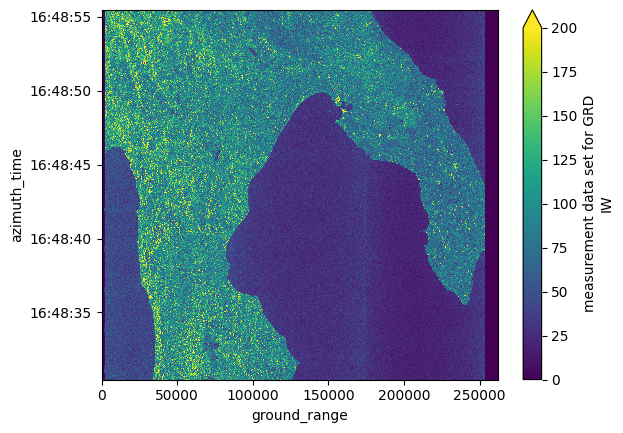

In [33]:
grd_decimated.plot(vmax=200)
plt.show()

### Sigma Nought and Digital Number

**calibration** subgroup inside `quality` is a very usefull subgroup to take a look at. Inside of it, among a few more, we'll find data concerning:
- `sigma_nought`or backscatter coefficient. It represents the strenght of the radar signal backscattered (or reflected back) from a target on earth's surface - expresses how much radar energy is reflected back toward the satellite from a unit area on the ground. It can be rescaled to decibels dB;
- `dn`, digital number and is the raw intensity data measured by the SAR sensor. It is unitless;

In [34]:
calibration = dt["S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/quality/calibration"].to_dataset()
calibration

<xarray.Dataset> Size: 292kB
Dimensions:       (azimuth_time: 27, ground_range: 657)
Coordinates:
  * azimuth_time  (azimuth_time) datetime64[ns] 216B 2017-05-08T16:48:30.4679...
  * ground_range  (ground_range) float64 5kB 0.0 6.677e+06 ... 4.38e+09
    line          (azimuth_time) uint32 108B dask.array<chunksize=(27,), meta=np.ndarray>
    pixel         (ground_range) uint32 3kB dask.array<chunksize=(657,), meta=np.ndarray>
Data variables:
    beta_nought   (azimuth_time, ground_range) float32 71kB dask.array<chunksize=(27, 657), meta=np.ndarray>
    dn            (azimuth_time, ground_range) float32 71kB dask.array<chunksize=(27, 657), meta=np.ndarray>
    gamma         (azimuth_time, ground_range) float32 71kB dask.array<chunksize=(27, 657), meta=np.ndarray>
    sigma_nought  (azimuth_time, ground_range) float32 71kB dask.array<chunksize=(27, 657), meta=np.ndarray>

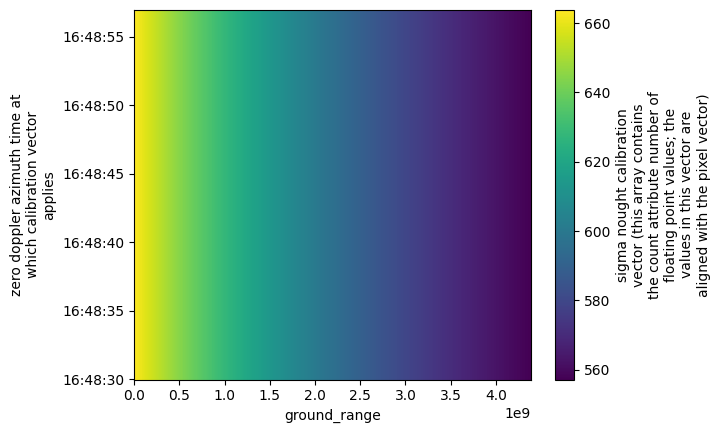

In [35]:
calibration.sigma_nought.plot()
plt.show()

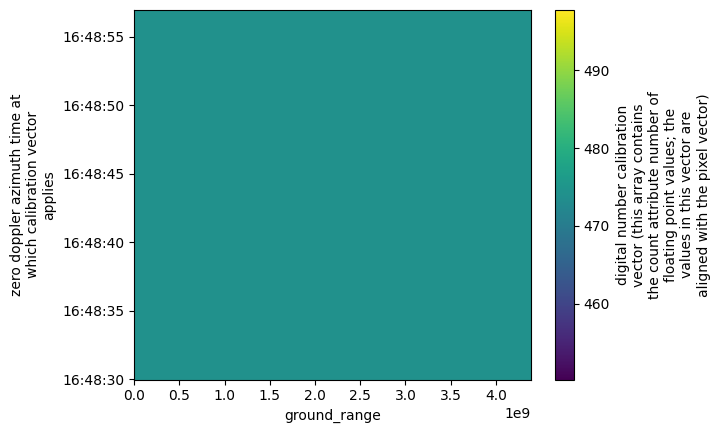

In [36]:
calibration.dn.plot()
plt.show()

And the reason why the graphic shown above only displays a specific color range is because the digital number is always the same throughout the whole image:

In [37]:
calibration.dn.values[1][1].item()

474.0

### GCP

**gcp** subgroup inside `conditions` it is also very important for the proecessing workflow on Sentinel-1 images. GCP stands for ground control points and are known and precise geolocated references on earth's surface. They can be used to later georeference the grd image. 

In [38]:
gcp = dt["S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/conditions/gcp"].to_dataset()
gcp

<xarray.Dataset> Size: 12kB
Dimensions:               (azimuth_time: 10, ground_range: 21)
Coordinates:
  * azimuth_time          (azimuth_time) datetime64[ns] 80B 2017-05-08T16:48:...
  * ground_range          (ground_range) float64 168B 0.0 ... 2.624e+05
    line                  (azimuth_time) uint32 40B dask.array<chunksize=(10,), meta=np.ndarray>
    pixel                 (ground_range) uint32 84B dask.array<chunksize=(21,), meta=np.ndarray>
Data variables:
    azimuth_time_gcp      (azimuth_time, ground_range) datetime64[ns] 2kB dask.array<chunksize=(10, 21), meta=np.ndarray>
    elevation_angle       (azimuth_time, ground_range) float64 2kB dask.array<chunksize=(10, 21), meta=np.ndarray>
    height                (azimuth_time, ground_range) float64 2kB dask.array<chunksize=(10, 21), meta=np.ndarray>
    incidence_angle       (azimuth_time, ground_range) float64 2kB dask.array<chunksize=(10, 21), meta=np.ndarray>
    latitude              (azimuth_time, ground_range) float64 2kB dask.array<chunksize=(10, 21), meta=np.ndarray>
    longitude             (azimuth_time, ground_range) float64 2kB dask.array<chunksize=(10, 21), meta=np.ndarray>
    slant_range_time_gcp  (azimuth_time, ground_range) float64 2kB dask.array<chunksize=(10, 21), meta=np.ndarray>

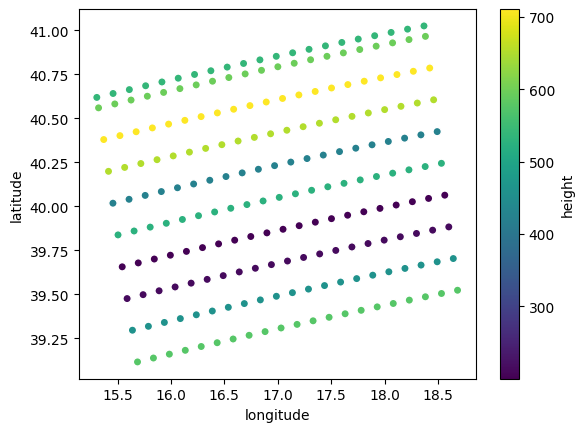

In [39]:
gcp.plot.scatter(x="longitude", y="latitude", hue="height")
plt.show()

### Orbit

**orbit** subgroup inside `conditions` is a variable that reflects how the orbital trajectory of the sattelite behaved during the flight. 

In [40]:
orbit = dt["S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/conditions/orbit"].to_dataset()
orbit

<xarray.Dataset> Size: 952B
Dimensions:       (azimuth_time: 17, axis: 3)
Coordinates:
  * azimuth_time  (azimuth_time) datetime64[ns] 136B 2017-05-08T16:47:24.0541...
Dimensions without coordinates: axis
Data variables:
    position      (azimuth_time, axis) float64 408B dask.array<chunksize=(17, 3), meta=np.ndarray>
    velocity      (azimuth_time, axis) float64 408B dask.array<chunksize=(17, 3), meta=np.ndarray>

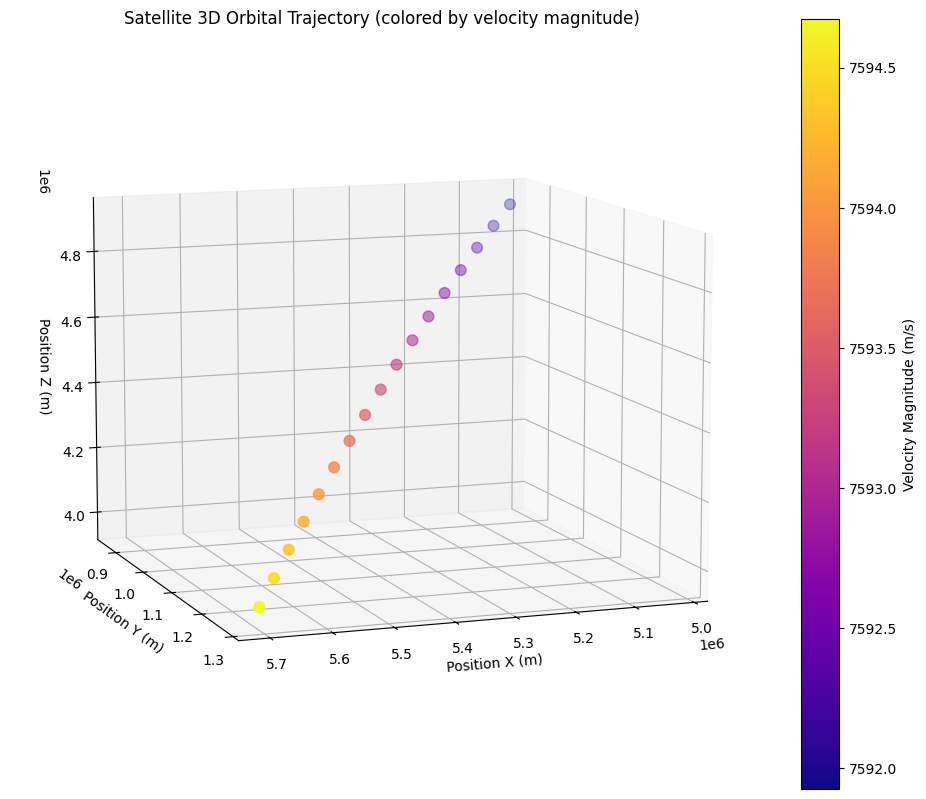

In [41]:
# Extract position components (X, Y, Z coordinates in space)
pos_x = orbit.position[:, 0]
pos_y = orbit.position[:, 1] 
pos_z = orbit.position[:, 2]

# Extract velocity components and calculate magnitude
vel_x = orbit.velocity[:, 0]
vel_y = orbit.velocity[:, 1]
vel_z = orbit.velocity[:, 2]
velocity_magnitude = np.sqrt(vel_x**2 + vel_y**2 + vel_z**2)

# Convert time to numeric for potential use in point sizing
time_numeric = (orbit.azimuth_time - orbit.azimuth_time[0]) / np.timedelta64(1, 's')

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# 3D scatter plot: X, Y, Z positions colored by velocity magnitude
scatter = ax.scatter(pos_x, pos_y, pos_z,
                    c=velocity_magnitude, cmap='plasma', s=60)

ax.set_xlabel('Position X (m)')
ax.set_ylabel('Position Y (m)')
ax.set_zlabel('Position Z (m)')
plt.colorbar(scatter, label='Velocity Magnitude (m/s)')
ax.set_title('Satellite 3D Orbital Trajectory (colored by velocity magnitude)')

# Set a good viewing angle
ax.view_init(elev=10, azim=70)
plt.show()

<hr>

## 💪 Now it is your turn

With everyhting you've learnt so far, you are now able to explore Sentinel-1 GRD product and plot some visuals. Try to to the following tasks:

### Task 1: Reproduce the workflow with your dataset
With all the knowledge you've gained, try to search and filter for a Sentinel-1 GRD of your interest and explore its data tree, plotting the same visuals.

### Task 2: Explore other variables
We've learnt how to look, explore and plot some specific variables inside the `.zarr` subgroups, but there are many more. Try to explore and understand what are some other variables.

### Task 3: Play with the image plotting
There are many ways to plot an image. Try to play with the variables you're plotting, changing the axis coordinates, maximum values shown or hue values.



## Conclusion

This tutorial provided the basics to explore and understand how the Sentinel-1 GRD is structured inside the `.zarr` format and what ot expect to find inside of it. We understood that `open_datatree()`and `open_dataset()` functions are still good alies to open and explore `.zarr`products, but so it is `.to_dataset()`funtion. It is also very easy and intuitive to plot the variables inside the Sentinel-1 GRD product.

## What's next?

On the next [chapter](24_S1_basic_operations.ipynb) we'll learn how to perform basic operations on `.zarr` Sentinel-1 GRD data, using some of the variables we've discovered today.